In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats 
from scipy.stats import levene, ttest_ind, t



In [2]:
chi_results =  pd.read_csv('all_years_updated_chicago_results.csv', low_memory=False)
weather_df =  pd.read_csv('marathon_weather_data_final.csv')


# Marathon Data Clean Up

In [3]:
# Get distinct years
unique_years = weather_df['Year'].unique()

# Convert to list
unique_weather_years_list = list(unique_years)
unique_weather_years_list = sorted(unique_weather_years_list)

In [4]:
chi_results.groupby('year')['marathon'].count().reset_index().rename(mapper={'marathon':'runner_count'},axis=1)

,year,runner_count
0,2001,28675
1,2002,31123
2,2003,32362
3,2004,33084
4,2005,32869
5,2006,33636
6,2007,25521
7,2008,31345
8,2009,33701
9,2010,36088


In [5]:
# Looking for smallest divisions in smallest race
chi_results[chi_results['year']==2001].groupby('gender')['division'].value_counts()

gender  division    
F       25-29           2845
        30-34           2368
        35-39           1895
        20-24           1612
        40-44           1264
        45-49            702
        50-54            370
        19 and under     143
        55-59            125
        60-64             28
        65-69             10
        70-74              3
        75-79              2
        80+                1
M       30-34           3555
        35-39           3191
        25-29           2756
        40-44           2618
        45-49           1740
        20-24           1228
        50-54           1201
        55-59            536
        60-64            226
        19 and under     159
        65-69             72
        70-74             15
        75-79              6
        80+                2
        –                  2
Name: division, dtype: int64

In [6]:
# remove rows where final time is null or disqualified
chi_results = chi_results.dropna(subset=['final_time'])
chi_results = chi_results[~chi_results['final_time'].isin(['PND'])]
chi_results.info()
# Function to convert HH:MM:SS into seconds
def convert_to_seconds(t):
    h, m, s = map(int, t.split(':'))
    return h * 3600 + m * 60 + s
chi_results['final_time_seconds'] = chi_results['final_time'].apply(convert_to_seconds)
chi_results.head()
# Map ages to groups
decade_mapper = {
          '20-24':'20s',
          '25-29':'20s',
          '30-34':'30s',
          '35-39':'30s',
          '40-44':'40s',
          '45-49':'40s',
          '50-54':'50s',
          '55-59':'50s'
          }
chi_results['age_decade'] = chi_results['division'].map(decade_mapper)
# rank all names to keep just the first occurance of each name to prevent selecting same person twice
chi_results_sorted_name = chi_results.sort_values(by=['year', 'name_ctz', 'final_time_seconds'])

chi_results['name_rank'] = chi_results_sorted_name.groupby(['year', 'name_ctz', 'final_time_seconds']).cumcount() + 1
chi_results = chi_results[chi_results['name_rank']==1]
chi_results.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797666 entries, 0 to 874307
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   index          797666 non-null  int64  
 1   place_overall  797666 non-null  float64
 2   gender_place   797666 non-null  float64
 3   name_ctz       797665 non-null  object 
 4   event          709955 non-null  object 
 5   bib            797666 non-null  object 
 6   division       797666 non-null  object 
 7   final_time     797666 non-null  object 
 8   marathon       797666 non-null  object 
 9   year           797666 non-null  int64  
 10  gender         797666 non-null  object 
 11  half_time      48125 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 79.1+ MB


,index,place_overall,gender_place,name_ctz,event,bib,division,final_time,marathon,year,gender,half_time,final_time_seconds,age_decade,name_rank
0,14,1.0,1.0,"Kimondiu, Ben (KEN)",Marathon,31,20-24,02:08:52,chicago,2001,M,NaN,7732,20s,1.0
1,22,2.0,2.0,"Tergat, Paul (KEN)",Marathon,8,30-34,02:08:56,chicago,2001,M,NaN,7736,30s,1.0
2,18,3.0,3.0,"Githuka, Peter (KEN)",Marathon,4,30-34,02:09:00,chicago,2001,M,NaN,7740,30s,1.0
3,20,4.0,4.0,"Ouaadi, Mohamed (FRA)",Marathon,7,30-34,02:09:26,chicago,2001,M,NaN,7766,30s,1.0
4,14,5.0,5.0,"Igarashi, Noriaki (JPN)",Marathon,10,25-29,02:09:35,chicago,2001,M,NaN,7775,20s,1.0


In [7]:
chi_results.groupby('name_ctz')['name_ctz'].count().sort_values()

name_ctz
Laveck, Victoria (USA)     1
Morse, Jennifer (CAN)      1
Morse, Haley (USA)         1
Morse, H. (USA)            1
Morse, Glenda (USA)        1
                          ..
Miller, Michael (USA)     55
Murphy, Michael (USA)     55
Smith, Jennifer (USA)     56
Smith, Michael (USA)      57
Johnson, Michael (USA)    64
Name: name_ctz, Length: 529135, dtype: int64

In [8]:
# exclude rows w/o division and small sample size divisions
chi_results = chi_results[~chi_results['division'].isin(['19 and under','–','99','M-15','W-15','60-64','65-69', '70-74', '75-79', '80+'])]
# Get distinct years
unique_div = chi_results['division'].unique()

# Convert to list
unique_race_divs = list(unique_div)
unique_race_divs

['20-24', '30-34', '25-29', '35-39', '40-44', '50-54', '45-49', '55-59']

In [9]:
# rank runners within their year, gender, age group by finish time
chi_results_sorted = chi_results.sort_values(by=['year', 'gender', 'age_decade', 'final_time_seconds'])

chi_results_sorted['group_place'] = chi_results_sorted.groupby(['year', 'gender', 'age_decade']).cumcount() + 1
chi_results_sorted.head()

,index,place_overall,gender_place,name_ctz,event,bib,division,final_time,marathon,year,gender,half_time,final_time_seconds,age_decade,name_rank,group_place
25,0,26.0,1.0,"Nderaba, Catherine (KEN)",Marathon,101,25-29,02:18:47,chicago,2001,F,NaN,8327,20s,1.0,1
31,14,32.0,2.0,"Alemu, Elfenesh (ETH)",Marathon,110,25-29,02:24:54,chicago,2001,F,NaN,8694,20s,1.0,2
78,8,79.0,7.0,"Naganuma, Ichiyo (JPN)",Marathon,111,25-29,02:34:02,chicago,2001,F,NaN,9242,20s,1.0,3
224,0,225.0,12.0,"Ray, Wendi (USA)",Marathon,1397,25-29,02:46:33,chicago,2001,F,NaN,9993,20s,1.0,4
303,24,304.0,16.0,"Lorenz, Kim (USA)",Marathon,1083,20-24,02:49:42,chicago,2001,F,NaN,10182,20s,1.0,5


In [10]:
# Keep just the top top runners
group_top = chi_results_sorted[chi_results_sorted['group_place']<=10]
# calculate the avg time in seconds for the top 10 finishers of each gender and age group
avg_group_top = group_top.groupby(['year','gender','age_decade'])['final_time_seconds'].mean().reset_index()
avg_group_top.rename(columns={'final_time_seconds': 'final_time_seconds_avg'}, inplace=True)


# Weather clean up

In [11]:
weather_df = weather_df[weather_df['Race']=='Chicago']
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 9 to 30
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Race                 22 non-null     object 
 1   Year                 22 non-null     int64  
 2   Date                 22 non-null     object 
 3   race_start           22 non-null     object 
 4   Humidity_hour1       22 non-null     int64  
 5   Humidity_hour2       22 non-null     int64  
 6   Humidity_hour3       22 non-null     int64  
 7   Humidity_hour4       22 non-null     int64  
 8   humidity_avg         22 non-null     float64
 9   wind_hour1           22 non-null     int64  
 10  wind_hour2           22 non-null     int64  
 11  wind_hour3           22 non-null     int64  
 12  wind_hour4           22 non-null     int64  
 13  wind_avg             22 non-null     float64
 14  temp_hour1           22 non-null     int64  
 15  temp_hour2           22 non-null     int64

In [12]:
# Calc avg temp per year
weather_df['temp_avg'] = weather_df[['temp_hour1','temp_hour2','temp_hour3']].mean(axis=1)
weather_cols = ['Race','Year','temp_avg']
weather_df = weather_df[weather_cols]
weather_df = weather_df.rename(columns={'Year': 'year'})
weather_df.head()

,Race,year,temp_avg
9,Chicago,2023,51.333333
10,Chicago,2022,55.333333
11,Chicago,2021,73.333333
12,Chicago,2019,46.333333
13,Chicago,2018,59.333333


In [13]:
# review temp dist
print('Min temp: '+ str(round(weather_df['temp_avg'].min(),2)))
print('Max temp: '+ str(round(weather_df['temp_avg'].max(),2)))
print('Median temp: ' + str(round(weather_df['temp_avg'].median(),2)))
print('Avg temp: '+ str(round(weather_df['temp_avg'].mean(),2)))
temp_median = weather_df['temp_avg'].median()

Min temp: 36.0
Max temp: 73.33
Median temp: 56.33
Avg temp: 56.11


# Combine Weather and Marathon Data

In [14]:
full_data = avg_group_top.merge(weather_df, how='left',on='year')
full_data['temp_group'] = full_data['temp_avg'].apply(lambda x: 'Under Median' if x < temp_median else 'Over Median')
full_data.sort_values(by=['year', 'gender', 'age_decade', 'final_time_seconds_avg']).head()

,year,gender,age_decade,final_time_seconds_avg,Race,temp_avg,temp_group
0,2001,F,20s,9830.3,Chicago,44.0,Under Median
1,2001,F,30s,9554.2,Chicago,44.0,Under Median
2,2001,F,40s,10673.4,Chicago,44.0,Under Median
3,2001,F,50s,12531.7,Chicago,44.0,Under Median
4,2001,M,20s,8037.7,Chicago,44.0,Under Median


In [15]:
ind_runners_full = group_top.merge(weather_df, how='left',on='year')
# Map data points to high and low temp groups (over/under temp median)
ind_runners_full['temp_group'] = ind_runners_full['temp_avg'].apply(lambda x: 'Under Median' if x < temp_median else 'Over Median')
ind_runners_full.head()

,index,place_overall,gender_place,name_ctz,event,bib,division,final_time,marathon,year,gender,half_time,final_time_seconds,age_decade,name_rank,group_place,Race,temp_avg,temp_group
0,0,26.0,1.0,"Nderaba, Catherine (KEN)",Marathon,101,25-29,02:18:47,chicago,2001,F,NaN,8327,20s,1.0,1,Chicago,44.0,Under Median
1,14,32.0,2.0,"Alemu, Elfenesh (ETH)",Marathon,110,25-29,02:24:54,chicago,2001,F,NaN,8694,20s,1.0,2,Chicago,44.0,Under Median
2,8,79.0,7.0,"Naganuma, Ichiyo (JPN)",Marathon,111,25-29,02:34:02,chicago,2001,F,NaN,9242,20s,1.0,3,Chicago,44.0,Under Median
3,0,225.0,12.0,"Ray, Wendi (USA)",Marathon,1397,25-29,02:46:33,chicago,2001,F,NaN,9993,20s,1.0,4,Chicago,44.0,Under Median
4,24,304.0,16.0,"Lorenz, Kim (USA)",Marathon,1083,20-24,02:49:42,chicago,2001,F,NaN,10182,20s,1.0,5,Chicago,44.0,Under Median


In [16]:
ind_runners_full = ind_runners_full[['name_ctz','year','gender','final_time_seconds','age_decade','temp_group']]
ind_runners_full.head()

,name_ctz,year,gender,final_time_seconds,age_decade,temp_group
0,"Nderaba, Catherine (KEN)",2001,F,8327,20s,Under Median
1,"Alemu, Elfenesh (ETH)",2001,F,8694,20s,Under Median
2,"Naganuma, Ichiyo (JPN)",2001,F,9242,20s,Under Median
3,"Ray, Wendi (USA)",2001,F,9993,20s,Under Median
4,"Lorenz, Kim (USA)",2001,F,10182,20s,Under Median


# Analyze Assumptions for Two Sample t-Test and Three Way ANOVA

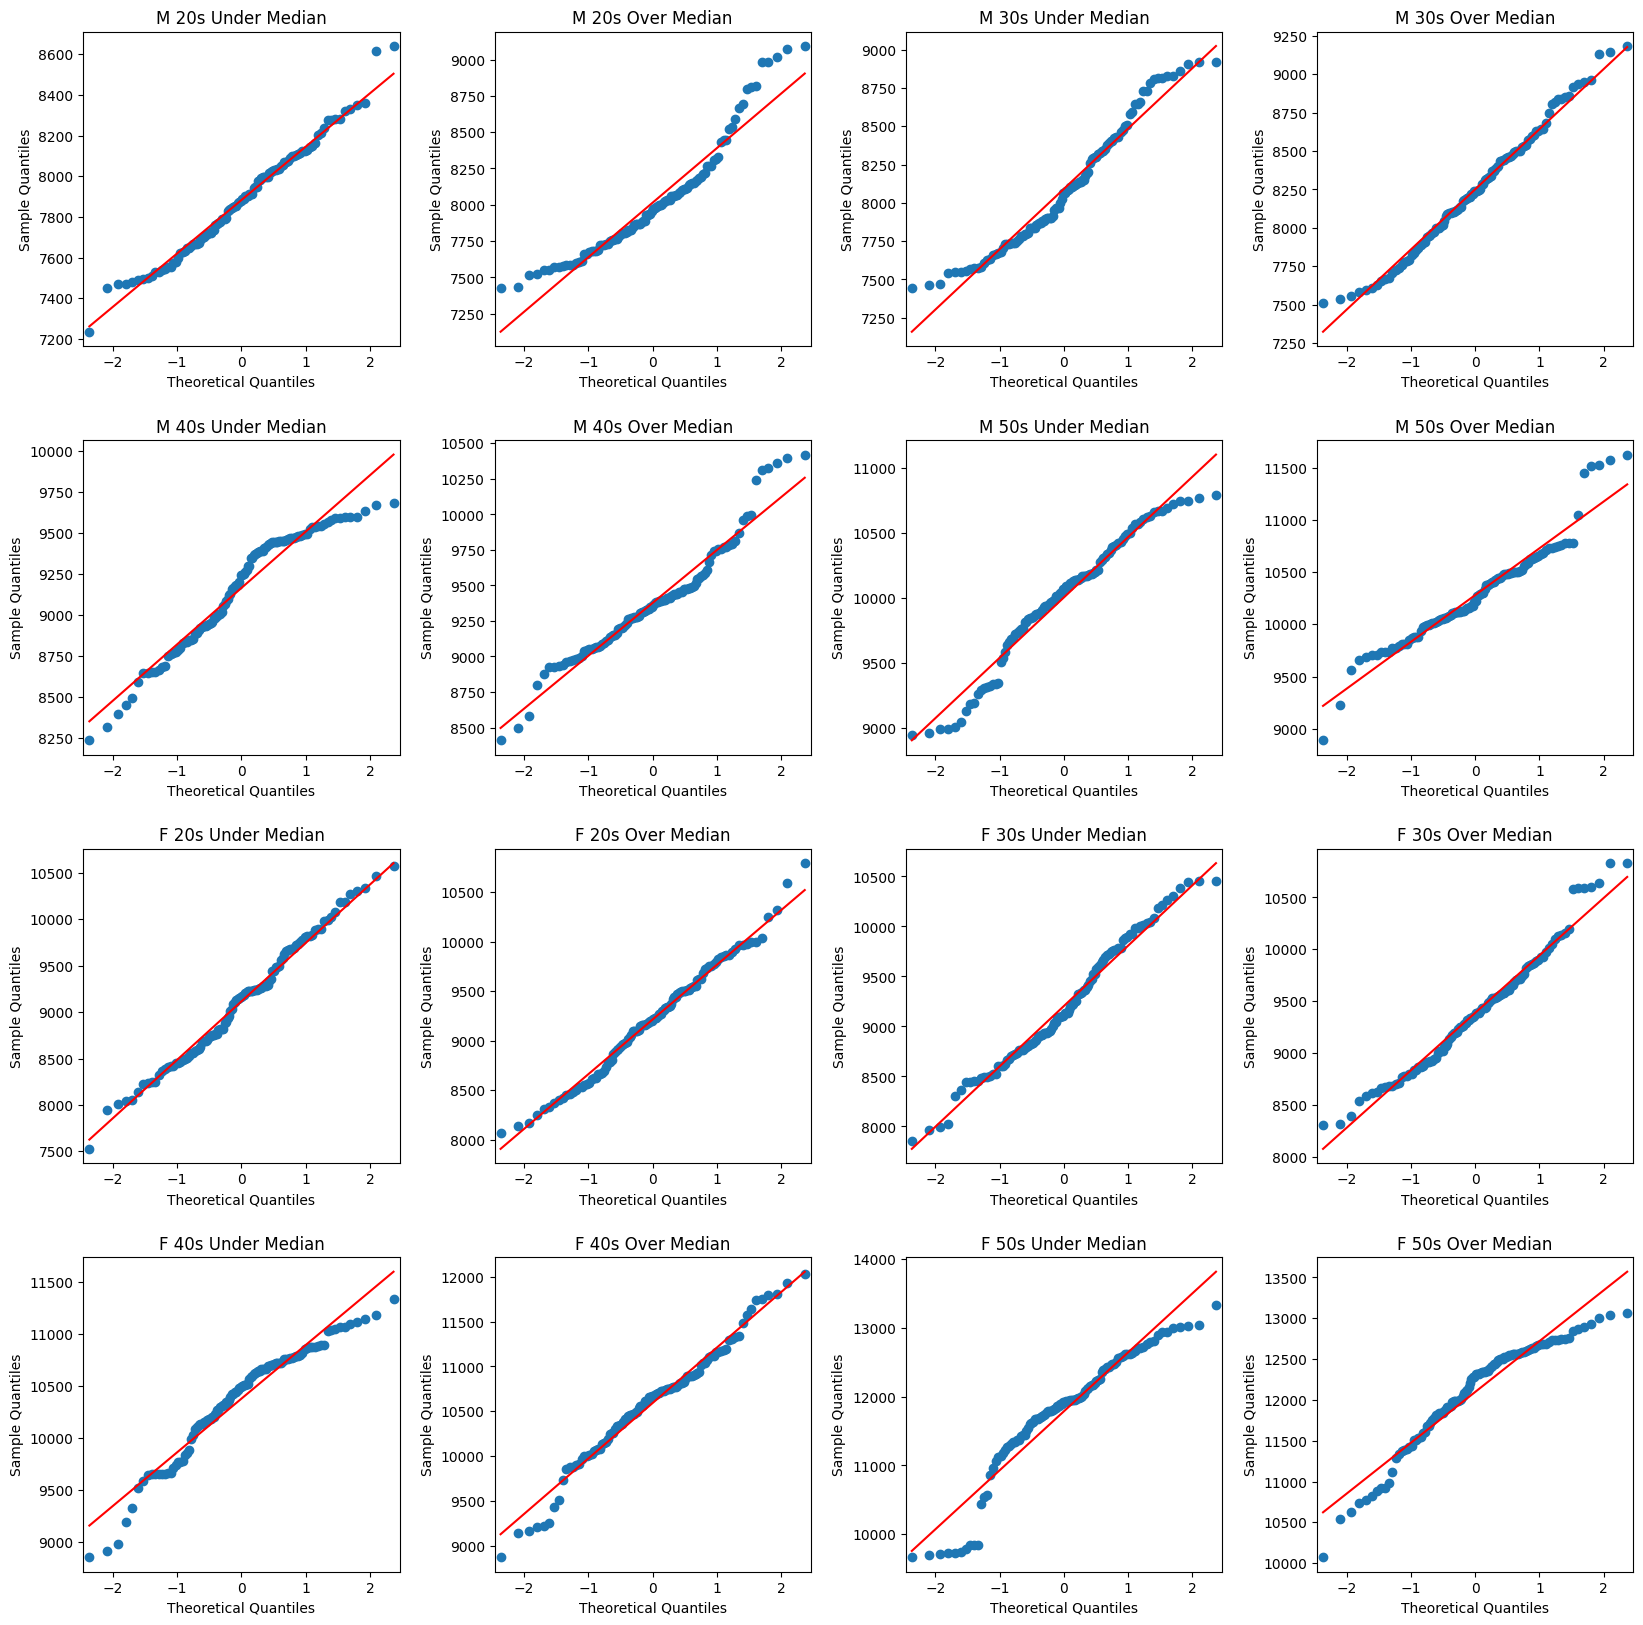

In [17]:
temp_groups = ['Under Median', 'Over Median']
gender_list = ['M','F']
decades = ['20s','30s','40s','50s']
# Set up the matplotlib figure with a 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.3) 

# Counter for subplot id
plot_counter = 0

# Loop through gender, decade, temp_group and plot
for gender in gender_list:
    for decade in decades:
        for temp_group in temp_groups:
            row = plot_counter // 4
            col = plot_counter % 4
            # Filter to current gender, decade, and temperature group combination
            filtered_df = ind_runners_full[(ind_runners_full['gender'] == gender) & 
                                           (ind_runners_full['age_decade'] == decade) & 
                                           (ind_runners_full['temp_group'] == temp_group)]
            data = filtered_df['final_time_seconds']  
            sm.qqplot(data, line='s', ax=axs[row, col])  
            axs[row, col].set_title(f'{gender} {decade} {temp_group}')
            plot_counter += 1  
            
plt.savefig('qq_plot2.png')
plt.show()


In [18]:
ind_runners_full['final_time_seconds_log'] = np.log(ind_runners_full['final_time_seconds'])
ind_runners_full['final_time_seconds_boxcox'], _ = stats.boxcox(ind_runners_full['final_time_seconds'])

levene_lists_log = []
levene_lists = []
levene_lists_boxcox =  []

# Create lists of each transformed final time
for gender in gender_list:
    for decade in decades:
        for temp_group in temp_groups: 
            filtered_df = ind_runners_full[(ind_runners_full['gender'] == gender) & 
                                           (ind_runners_full['age_decade'] == decade) & 
                                           (ind_runners_full['temp_group'] == temp_group)]
            data_log = filtered_df['final_time_seconds_log']
            data_boxcox = filtered_df['final_time_seconds_boxcox']
            data = filtered_df['final_time_seconds']
            levene_lists_log.append(list(data_log))
            levene_lists.append(list(data))
            levene_lists_boxcox.append(data_boxcox)
# Run Levene's test
stat_log, p_value_log = levene(*levene_lists_log)
stat_boxcox, p_value_boxcox = levene(*levene_lists_boxcox)
stat_sec, p_value_sec = levene(*levene_lists)

# Display
levene_results_log = pd.DataFrame({
    "Levene's Test": ["Untransformed Data", " Log Transformed", "Box-Cox Transformation"],
    "Statistic": [stat_sec,stat_log,stat_boxcox],
    "p-value": [p_value_sec,p_value_log,p_value_boxcox]
})
display(levene_results_log)

,Levene's Test,Statistic,p-value
0,Untransformed Data,12.065845,6.585161e-29
1,Log Transformed,7.805492,3.076309e-17
2,Box-Cox Transformation,8.100427,4.841487e-18


# Conduct Welchs t-Tests

In [19]:
def analyze_groups(df, gender, age_decade):
    # Filter data for the specific gender and age_decade
    filtered_df = df[(df['gender'] == gender) & (df['age_decade'] == age_decade)]
    
    # Split data into two groups based on temp_group
    group_under_median = filtered_df[filtered_df['temp_group'] == 'Under Median']['final_time_seconds']
    group_over_median = filtered_df[filtered_df['temp_group'] == 'Over Median']['final_time_seconds']

    # Calc Means of each group
    avg_under_median = group_under_median.mean()
    avg_over_median = group_over_median.mean()

    # Levene test between two groups
    equal_var_test = levene(group_under_median, group_over_median)
    
    # Perform unequal variance two-sample t-test
    t_test_result = ttest_ind(group_under_median, group_over_median, equal_var=False)
    
    # Calculate Confidence Interval w/ bonferroni adjustment
    n_under = group_under_median.size
    n_over = group_over_median.size
    m_under = group_under_median.mean()
    m_over = group_over_median.mean()
    v_under = group_under_median.var()
    v_over = group_over_median.var()

    pooled_se = np.sqrt(v_under / n_under + v_over / n_over)
    delta = m_under-m_over
    df = (v_under / n_under + v_over / n_over)**2 / (v_under**2 / (n_under**2 * (n_under - 1)) + v_over**2 / (n_over**2 * (n_over - 1)))

    lb = delta - t.ppf(1-(.05/8),df)*pooled_se 
    ub = delta + t.ppf(1-(.05/8),df)*pooled_se
    
    return [gender, age_decade, round(avg_under_median,2), round(avg_over_median,2),round(avg_over_median-avg_under_median,2),'['+str(round(lb,2))+', '+str(round(ub,2))+']', round(t_test_result.statistic,3), t_test_result.pvalue, equal_var_test.pvalue , lb, ub]
    

In [20]:
gender_list = ['M','F']
decades = ['20s','30s','40s','50s']
results = [['Gender','Age Decade', 'Low Temp Avg Time (sec)', 'High Temp Avg Time (sec)', 'Mean Diff', '99.375% CI', 't-Test Statistic','t-Test P Value', 'Levene Test P Value', 'lb','ub']]
for g in gender_list:
    for decade in decades:
        results.append(analyze_groups(ind_runners_full, g, decade))

In [21]:
column_names = results[0]
data_rows = results[1:]

# Create the DataFrame
results_df = pd.DataFrame(data_rows, columns=column_names)
levene_test_results = results_df[['Gender','Age Decade','Levene Test P Value']]
ci_df = results_df[['Gender','Age Decade','lb','ub']]
results_df = results_df[['Gender','Age Decade', 'Low Temp Avg Time (sec)', 'High Temp Avg Time (sec)', 'Mean Diff', '99.375% CI', 't-Test Statistic','t-Test P Value']]
levene_test_results

,Gender,Age Decade,Levene Test P Value
0,M,20s,0.015863
1,M,30s,0.736565
2,M,40s,0.455535
3,M,50s,0.609639
4,F,20s,0.126447
5,F,30s,0.196821
6,F,40s,0.232875
7,F,50s,0.064845


In [22]:
results_df

,Gender,Age Decade,Low Temp Avg Time (sec),High Temp Avg Time (sec),Mean Diff,99.375% CI,t-Test Statistic,t-Test P Value
0,M,20s,7882.99,8015.13,132.14,"[-242.84, -21.43]",-3.009,0.002965
1,M,30s,8091.07,8250.17,159.10,"[-293.15, -25.05]",-2.989,0.003117
2,M,40s,9165.35,9377.34,211.98,"[-334.33, -89.63]",-4.364,0.000020
3,M,50s,10005.55,10280.09,274.55,"[-430.25, -118.84]",-4.441,0.000014
4,F,20s,9115.13,9214.04,98.91,"[-300.92, 103.1]",-1.233,0.218795
5,F,30s,9204.48,9388.43,183.95,"[-381.55, 13.66]",-2.345,0.019949
6,F,40s,10380.92,10592.46,211.55,"[-406.12, -16.97]",-2.739,0.006690
7,F,50s,11787.67,12096.82,309.15,"[-565.2, -53.09]",-3.043,0.002657


# Format and Display Results

In [23]:
display_df = results_df.copy()
display_df['Low Temp Avg Time (sec)'] = display_df['Low Temp Avg Time (sec)'].apply(lambda x: f"{x:.2f}")
display_df['High Temp Avg Time (sec)'] = display_df['High Temp Avg Time (sec)'].apply(lambda x: f"{x:.2f}")
display_df['Mean Diff'] = display_df['Mean Diff'].apply(lambda x: f"{x:.2f}")
display_df['t-Test Statistic'] = display_df['t-Test Statistic'].apply(lambda x: f"{x:.3f}")

In [24]:
# color statsig rows green, otherwise red
def color_rows(val):
    color = 'lightgreen' if val < .00625 else 'lightcoral'
    return f'background-color: {color}'

display_df = display_df.style.applymap(color_rows, subset=['t-Test P Value'])  # Applies the function to column 'A'
display_df

,Gender,Age Decade,Low Temp Avg Time (sec),High Temp Avg Time (sec),Mean Diff,99.375% CI,t-Test Statistic,t-Test P Value
0,M,20s,7882.99,8015.13,132.14,"[-242.84, -21.43]",-3.009,0.002965
1,M,30s,8091.07,8250.17,159.10,"[-293.15, -25.05]",-2.989,0.003117
2,M,40s,9165.35,9377.34,211.98,"[-334.33, -89.63]",-4.364,0.000020
3,M,50s,10005.55,10280.09,274.55,"[-430.25, -118.84]",-4.441,0.000014
4,F,20s,9115.13,9214.04,98.91,"[-300.92, 103.1]",-1.233,0.218795
5,F,30s,9204.48,9388.43,183.95,"[-381.55, 13.66]",-2.345,0.019949
6,F,40s,10380.92,10592.46,211.55,"[-406.12, -16.97]",-2.739,0.006690
7,F,50s,11787.67,12096.82,309.15,"[-565.2, -53.09]",-3.043,0.002657


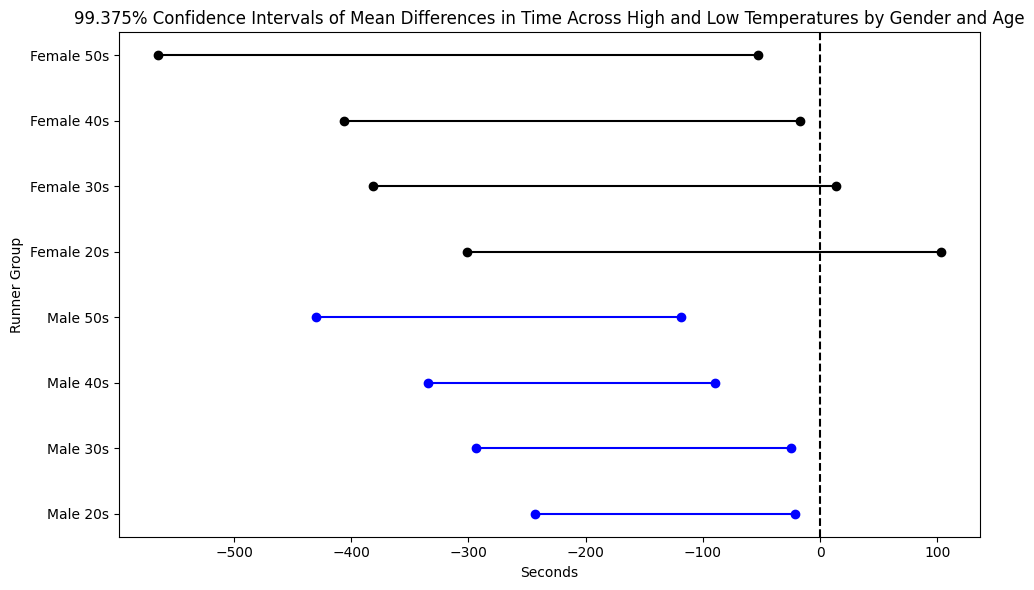

In [25]:
# labels for groups
gender_age_groups = ["Male 20s", "Male 30s", "Male 40s", "Male 50s", "Female 20s", "Female 30s", "Female 40s", "Female 50s"]

plt.figure(figsize=(10, 6))

# Create horizontal lines for each group
for i, row in ci_df.iterrows():
    plt.plot([row['lb'], row['ub']], [i, i], marker='o', linestyle='-', color='blue' if row['Gender'] == 'M' else 'black')

# Vert line at 0
plt.axvline(x=0, color='black', linestyle='--')

# Adding labels and title
plt.yticks([])
plt.xlabel('Seconds')
plt.ylabel('Runner Group')
plt.title('99.375% Confidence Intervals of Mean Differences in Time Across High and Low Temperatures by Gender and Age')
plt.grid(False)
plt.yticks(range(len(gender_age_groups)), [f"{gender_decade}" for gender_decade in gender_age_groups])

plt.tight_layout()
plt.savefig('ci_plot.png')

plt.show()